In [1]:
import sys
sys.path.append('..')
from models.scnn_pytorch.model import SCNN
from models.erfnet.erfnet import ERFNet
import torch
import os
import cv2
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt

In [4]:
drive_window_region = np.array([600.0 / 1920, 280.0 / 1080, 1000.0 / 1920, 360.0 / 1080])


def GetRectFromRegion(region: np.array, width, height):
    x = float(width) * region[0]
    y = float(height) * region[1]
    region_width = float(width) * region[2]
    region_height = float(height) * region[3]
    return np.array([x, y, region_width, region_height], dtype=np.int)

rect = GetRectFromRegion(drive_window_region, 1920, 1080)

In [22]:
MODEL_DIR = '../models/scnn_pytorch'
INPUT_SIZE = (800, 288)
net = SCNN(input_size=INPUT_SIZE, pretrained=False, test=True)
state = torch.load(MODEL_DIR + '/exp10_best.pth')
net.load_state_dict(state['net'])
net.eval().cuda().half()

mean = (0.3598, 0.3653, 0.3662)
std = (0.2573, 0.2663, 0.2756)

cv2.namedWindow('result')

for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    input_blob = drive_window_img.astype(np.float)
    input_blob = input_blob / 255.0
    input_blob = (input_blob - mean) / std
    input_blob = cv2.resize(input_blob, INPUT_SIZE)
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = torch.from_numpy(np.array([input_blob]))
    input_tensor = input_tensor.float().cuda().half()

    seg, exist = net(input_tensor)
    seg_img = seg.cpu().numpy().astype(np.uint8)

    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_GRAY2RGB)
    seg_img = cv2.resize(seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(seg_img * 50, 0.5, drive_window_img, 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')

In [5]:
net = ERFNet(5)
input_mean = net.input_mean
input_std = net.input_std
net= torch.nn.DataParallel(net, device_ids=[0]).cuda()
checkpoint = torch.load('D:/Dev/Codes-for-Lane-Detection/ERFNet-CULane-PyTorch/trained/ERFNet_trained.tar')

In [6]:
net.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [8]:
cv2.namedWindow('result')
cv2.moveWindow('result', 200,200)
for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)

    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]-200]
    input_blob = drive_window_img.astype(np.float)
    input_blob = input_blob
    input_blob = (input_blob - input_mean) / input_std
    input_blob = cv2.resize(input_blob, (976, 208))
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = torch.from_numpy(np.array([input_blob]))
    input_tensor = input_tensor.float().cuda()

    seg, exist = net(input_tensor)

    seg = seg.detach().cpu().numpy()
    seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)
    

    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_GRAY2RGB)
    seg_img = cv2.resize(seg_img, (1280, 720), interpolation=cv2.INTER_LINEAR)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(seg_img * 50, 0.5, drive_window_img, 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')

In [31]:
input_mean

[103.939, 116.779, 123.68]

In [4]:
sys.path.append('../models/PINet')
from models.PINet import agent

In [5]:
net = agent.Agent()
state = torch.load('../models/PINet/savefile/640_tensor(0.2298)_lane_detection_network.pkl')
net.lane_detection_network.load_state_dict(state)
net.cuda()
net.evaluate_mode()

In [55]:
test_image = cv2.imread("../images/1591496736089.png")
test_image = cv2.resize(test_image, (512,256))/255.0
input_blob = test_image.transpose([2, 0, 1])
input_blob = np.array([input_blob])

confidences, offsets, instances = net.predict_lanes_test(input_blob)[-1]

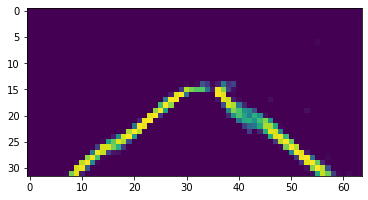

In [56]:
confidences = (confidences[0][0].detach().cpu().numpy())*50
confidences = confidences.astype(np.uint8)
plt.imshow(confidences)

In [49]:
cv2.namedWindow('result')
cv2.moveWindow('result', 200,200)
for filename in os.listdir('../images'):
    img = cv2.imread('../images/' + filename)

    drive_window_img = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]-200]
    input_blob = drive_window_img.astype(np.float)
    input_blob = cv2.resize(input_blob, (512,256)) / 255.0
    input_blob = input_blob.transpose([2, 0, 1])

    input_tensor = np.array([input_blob])

    confidences, offsets, instances = net.predict_lanes_test(input_tensor)[-1]

    confidences = (confidences[0][0].detach().cpu().numpy())*50
    confidences = confidences.astype(np.uint8)
#     seg_img = np.argmax(seg[0], axis=0).astype(np.uint8)
    

    confidences = cv2.cvtColor(confidences, cv2.COLOR_GRAY2RGB)
    seg_img = cv2.resize(confidences, (1280, 720), interpolation=cv2.INTER_NEAREST)
    drive_window_img = cv2.resize(drive_window_img, (1280, 720))
    blend = cv2.addWeighted(seg_img * 50, 0.5, drive_window_img, 0.8, 0)

    cv2.imshow('result', blend)
    if cv2.waitKey(500) == 27:
        break
cv2.destroyWindow('result')